<a href="https://colab.research.google.com/github/NicoFuentese/Ciencia_De_Datos_TD2025/blob/main/7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#dependencias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

def plot_bar_series(df, label_col, top_n=None):
    """Grafica barras por país para cada género (distribución comparativa).
    Requiere matplotlib (sin estilos ni colores específicos).
    """
    feature_cols = [c for c in df.columns if c != label_col]
    n = len(feature_cols)
    rows = int(np.ceil(n/2))
    # Grafica cada feature en su propio plot, uno por vez para cumplir la regla de 'un gráfico por figura'.
    for col in feature_cols:
        plt.figure()
        plt.bar(df[label_col].astype(str), df[col].astype(float))
        plt.title(f"{col} por país")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

def plot_elbow_silhouette(X, k_range):
    inertias, silhouettes = [], []
    for k in k_range:
        if k <= 1 or k >= len(X):
            inertias.append(np.nan); silhouettes.append(np.nan)
            continue
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)
        try:
            silhouettes.append(silhouette_score(X, labels))
        except Exception:
            silhouettes.append(np.nan)
    # Elbow
    plt.figure()
    plt.plot(k_range, inertias, marker='o')
    plt.title('Método del codo (inertia vs K)')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()
    # Silhouette
    plt.figure()
    plt.plot(k_range, silhouettes, marker='o')
    plt.title('Coeficiente de silueta promedio vs K')
    plt.xlabel('K')
    plt.ylabel('Silhouette')
    plt.grid(True)
    plt.show()

def label_scatter(points_2d, labels, title, label_names=None, cluster_assignments=None):
    plt.figure()
    x, y = points_2d[:,0], points_2d[:,1]
    plt.scatter(x, y)
    for i, txt in enumerate(labels):
        suffix = '' if cluster_assignments is None else f" (C{int(cluster_assignments[i])})"
        plt.annotate(str(txt)+suffix, (x[i], y[i]))
    plt.title(title)
    plt.tight_layout()
    plt.show()


Columna etiqueta: País
Columnas de características: ['Pop', 'Rock', 'Hip-Hop', 'Electrónica', 'Clásica', 'Jazz', 'Reguetón', 'Metal']


,País,Pop,Rock,Hip-Hop,Electrónica,Clásica,Jazz,Reguetón,Metal
0,Chile,71,22,79,61,70,58,79,69
1,EEUU,34,41,40,79,74,37,90,23
2,México,91,72,52,99,83,23,63,21
3,Corea,80,21,95,34,22,79,27,25
4,Japón,40,49,77,81,70,33,66,73



Descripción estadística:


,Pop,Rock,Hip-Hop,Electrónica,Clásica,Jazz,Reguetón,Metal
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000,8.000000
mean,68.375000,45.750000,66.250000,72.750000,59.625000,43.875000,66.37500,48.625000
std,25.628876,23.980647,19.912308,19.337233,26.586449,22.680624,22.36028,27.650562
min,34.000000,21.000000,40.000000,34.000000,22.000000,21.000000,27.00000,21.000000
25%,42.250000,21.750000,49.250000,64.750000,36.500000,26.750000,54.75000,23.000000
50%,75.500000,45.000000,72.500000,80.000000,70.000000,35.000000,64.50000,47.000000
75%,91.750000,60.750000,78.250000,81.000000,76.250000,61.500000,81.75000,73.000000
max,94.000000,83.000000,95.000000,99.000000,92.000000,79.000000,97.00000,82.000000


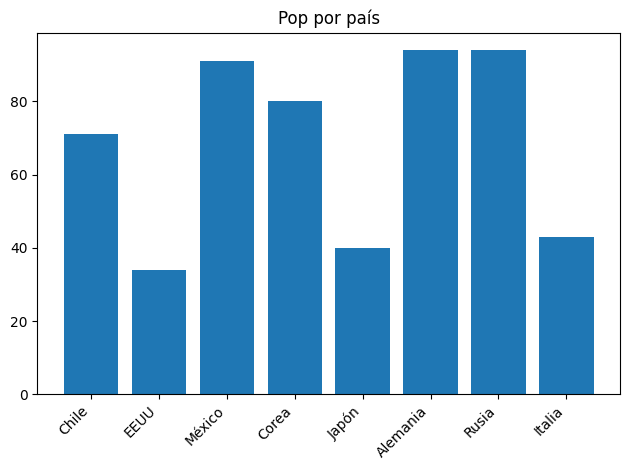

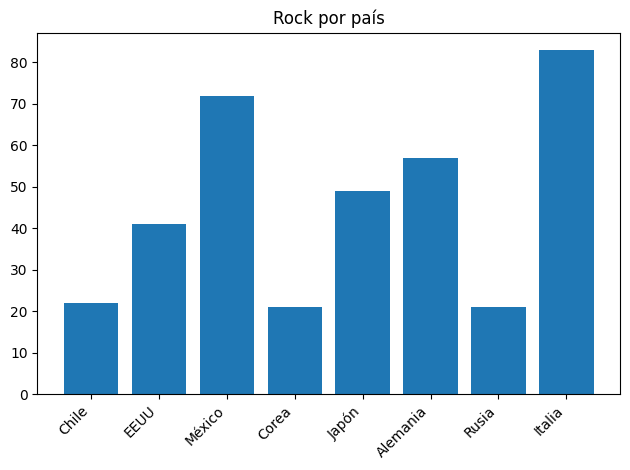

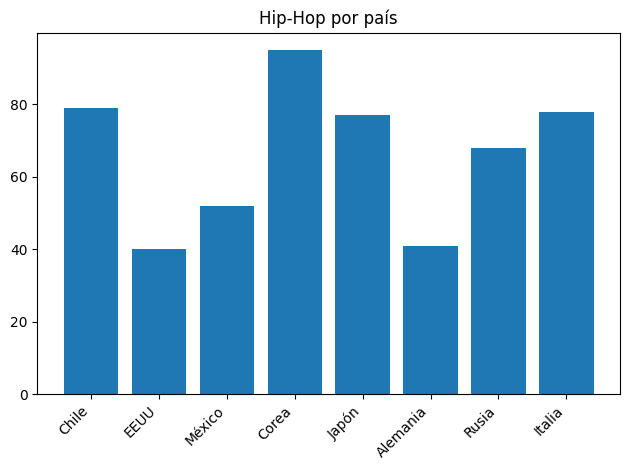

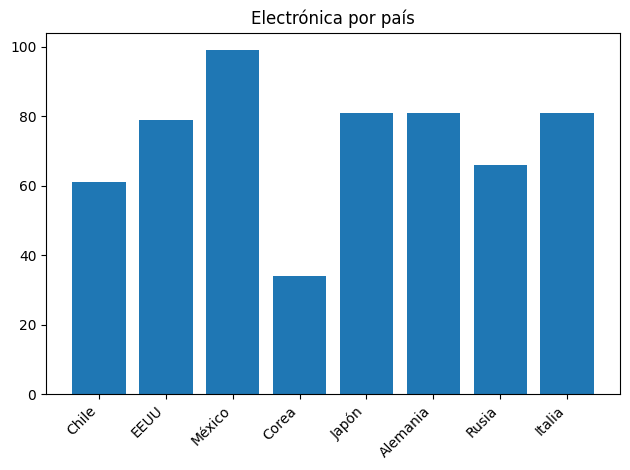

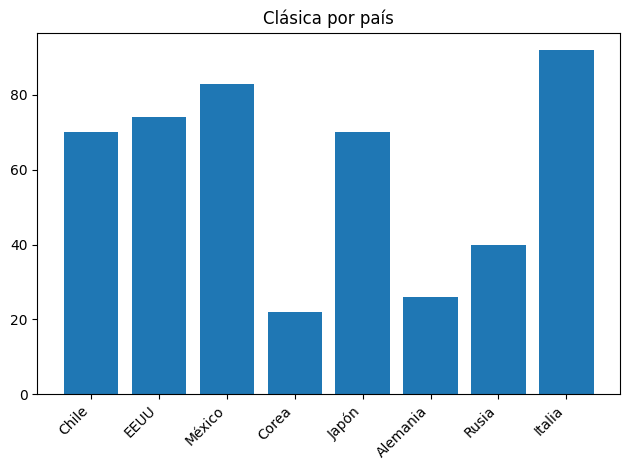

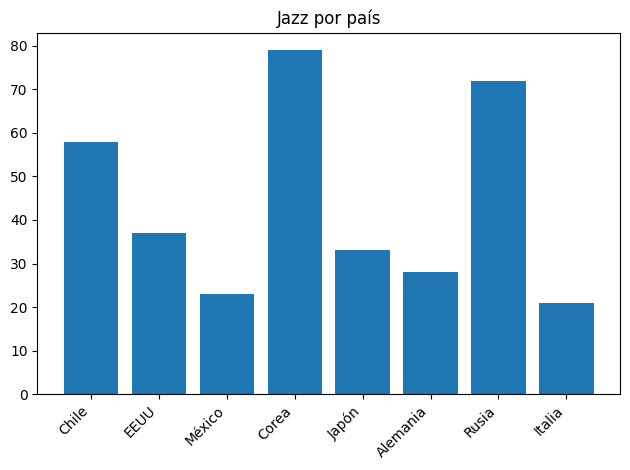

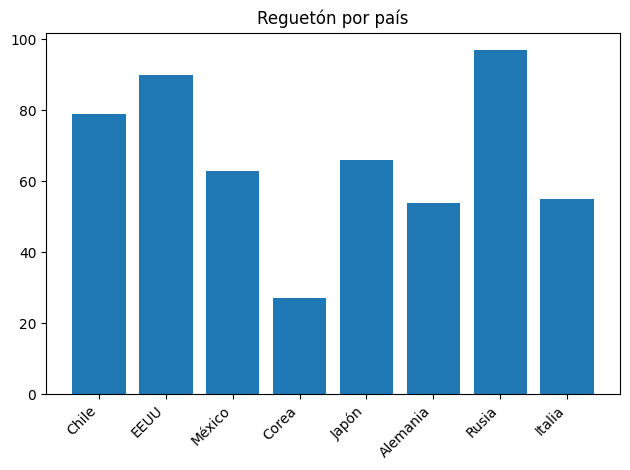

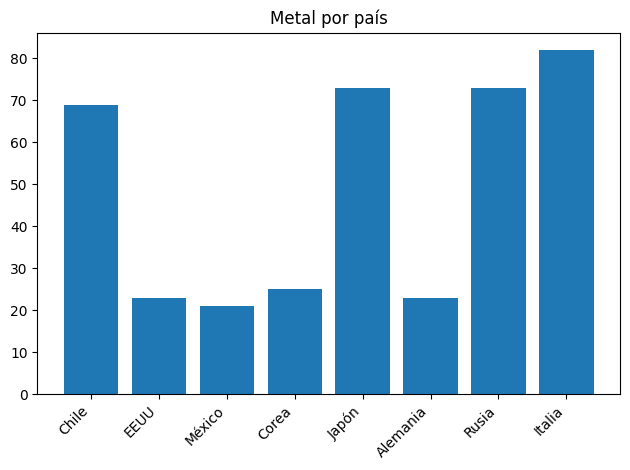

In [ ]:
CSV_PATH = 'dataset_generos_musicales.csv'

df = pd.read_csv(CSV_PATH)

# Detectar columna de país (nombre) y features numéricas
possible_label_cols = ['País', 'Pais', 'Country', 'country', 'pais']
label_col = None
for c in possible_label_cols:
    if c in df.columns:
        label_col = c
        break
if label_col is None:
    # Si no existe, asumimos la primera columna como etiqueta
    label_col = df.columns[0]

feature_cols = [c for c in df.columns if c != label_col]

print('Columna etiqueta:', label_col)
print('Columnas de características:', feature_cols)
display(df.head())

print('\nDescripción estadística:')
display(df[feature_cols].describe(include='all'))

# Distribuciones básicas por país
plot_bar_series(df, label_col)


In [ ]:
# === Preprocesamiento (Escalado) ===
X = df[feature_cols].values.astype(float)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
countries = df[label_col].astype(str).values

print('Forma de X:', X.shape)
print('Primeras filas escaladas:')
print(pd.DataFrame(X_scaled, columns=feature_cols).head())

Forma de X: (8, 8)
Primeras filas escaladas:
        Pop      Rock   Hip-Hop  Electrónica   Clásica      Jazz  Reguetón     Metal
0  0.109495 -1.058763  0.684518    -0.649590  0.417180  0.665778  0.603601  0.787752
1 -1.433868 -0.211753 -1.409301     0.345527  0.578021 -0.324051  1.129511 -0.990731
2  0.943746  1.170212 -0.765049     1.451212  0.939912 -0.983937 -0.161359 -1.068057
3  0.484908 -1.103342  1.543520    -2.142266 -1.512907  1.655607 -1.882519 -0.913406
4 -1.183593  0.144883  0.577142     0.456095  0.417180 -0.512590 -0.017929  0.942403


Asignaciones con K=3:


,País,Cluster_K3
0,Chile,1
1,EEUU,0
2,México,0
3,Corea,1
4,Japón,2
5,Alemania,0
6,Rusia,1
7,Italia,2


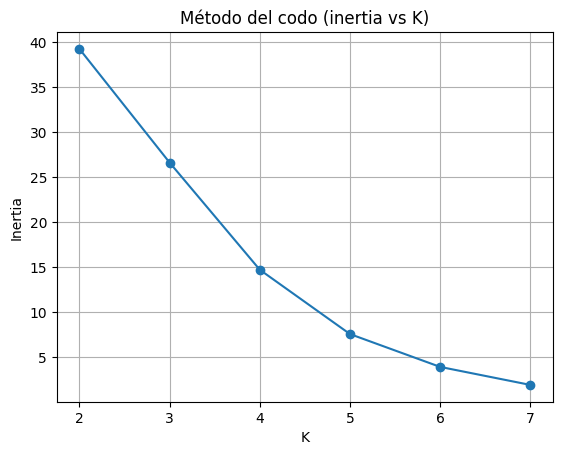

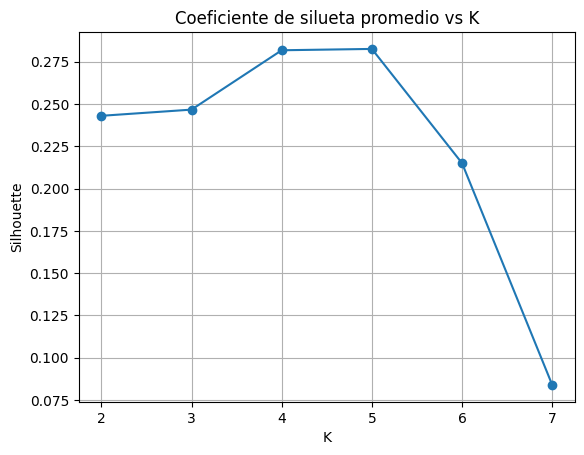

Mejor K por silhouette (~heurístico): 5 (silhouette=0.283)


,País,Cluster_KMeans
2,México,0
5,Alemania,0
4,Japón,1
7,Italia,1
0,Chile,2
6,Rusia,2
3,Corea,3
1,EEUU,4


In [ ]:
# === 2) Clusterización: K-Means ===
# K inicial = 3
k_init = 3
kmeans_init = KMeans(n_clusters=k_init, random_state=42, n_init=10)
labels_k3 = kmeans_init.fit_predict(X_scaled)

print('Asignaciones con K=3:')
display(pd.DataFrame({'País': countries, 'Cluster_K3': labels_k3}))

# Búsqueda de K óptimo con codo y silhouette
k_range = list(range(2, min(8, len(countries))))  # con n pequeño, limitamos K
plot_elbow_silhouette(X_scaled, k_range)

# Elegimos K con mejor trade-off: máximo silhouette (con sentido) como ejemplo
best_k, best_sil = None, -1
for k in k_range:
    if k <= 1: continue
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    labels_k = km.labels_
    try:
        sil = silhouette_score(X_scaled, labels_k)
        if sil > best_sil:
            best_sil, best_k = sil, k
    except Exception:
        pass

best_k = best_k if best_k is not None else 3
print(f"Mejor K por silhouette (~heurístico): {best_k} (silhouette={best_sil:.3f})")
kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_k_best = kmeans_best.fit_predict(X_scaled)
assign_kmeans = pd.DataFrame({'País': countries, 'Cluster_KMeans': labels_k_best})
display(assign_kmeans.sort_values('Cluster_KMeans'))

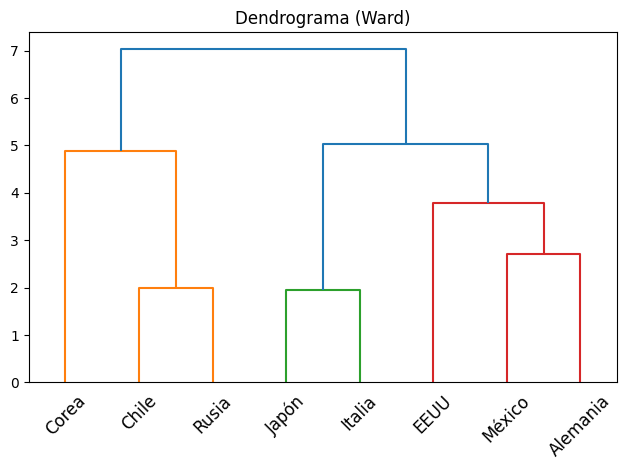

,País,Cluster_Hier
0,Chile,0
6,Rusia,0
3,Corea,1
4,Japón,2
7,Italia,2
2,México,3
5,Alemania,3
1,EEUU,4


Adjusted Rand Index (KMeans vs Jerárquico): 1.000


In [ ]:
# === Clusterización Jerárquica (Ward) ===
Z = linkage(X_scaled, method='ward')

# Dendrograma
plt.figure()
dendrogram(Z, labels=countries, leaf_rotation=45)
plt.title('Dendrograma (Ward)')
plt.tight_layout()
plt.show()

# Regla simple para elegir número de clusters: usar el mejor_k hallado por KMeans como referencia
labels_hier = fcluster(Z, t=best_k, criterion='maxclust') - 1  # normalizamos a 0..K-1
assign_hier = pd.DataFrame({'País': countries, 'Cluster_Hier': labels_hier})
display(assign_hier.sort_values('Cluster_Hier'))

# Comparación KMeans vs Jerárquico
ari = adjusted_rand_score(labels_k_best, labels_hier)
print(f"Adjusted Rand Index (KMeans vs Jerárquico): {ari:.3f}")


In [ ]:
# === DBSCAN ===
# Con pocos puntos (8 países), DBSCAN puede ofrecer resultados limitados.
# Probaremos una rejilla pequeña de parámetros.
eps_values = [0.5, 0.7, 0.9, 1.1, 1.5, 2.0]
min_samples_values = [2, 3]

results = []
for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms).fit(X_scaled)
        labels = db.labels_
        # clusters válidos son etiquetas >= 0 (el -1 es ruido)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)
        results.append((eps, ms, n_clusters, n_noise))

res_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'n_clusters', 'n_noise'])
display(res_df)

# Elegimos una configuración con al menos 2 clusters y poco ruido si existe
candidates = res_df[(res_df['n_clusters'] >= 2)]
if len(candidates):
    chosen = candidates.sort_values(['n_noise','n_clusters'], ascending=[True, False]).iloc[0]
else:
    chosen = res_df.sort_values(['n_noise','n_clusters'], ascending=[True, False]).iloc[0]

print('Parámetros DBSCAN elegidos:', dict(chosen))
db = DBSCAN(eps=float(chosen['eps']), min_samples=int(chosen['min_samples'])).fit(X_scaled)
labels_db = db.labels_
assign_db = pd.DataFrame({'País': countries, 'Cluster_DBSCAN': labels_db})
display(assign_db.sort_values('Cluster_DBSCAN'))

,eps,min_samples,n_clusters,n_noise
0,0.5,2,0,8
1,0.5,3,0,8
2,0.7,2,0,8
3,0.7,3,0,8
4,0.9,2,0,8
5,0.9,3,0,8
6,1.1,2,0,8
7,1.1,3,0,8
8,1.5,2,0,8
9,1.5,3,0,8


Parámetros DBSCAN elegidos: {'eps': np.float64(2.0), 'min_samples': np.float64(2.0), 'n_clusters': np.float64(1.0), 'n_noise': np.float64(6.0)}


,País,Cluster_DBSCAN
0,Chile,-1
1,EEUU,-1
2,México,-1
3,Corea,-1
5,Alemania,-1
6,Rusia,-1
4,Japón,0
7,Italia,0


Varianza explicada por componente: [0.4603 0.2372 0.1735 0.0857 0.0333 0.0064 0.0035 0.    ]
Varianza acumulada: [0.4603 0.6975 0.871  0.9567 0.9901 0.9965 1.     1.    ]
Componentes necesarios para ≥90% de varianza: 4


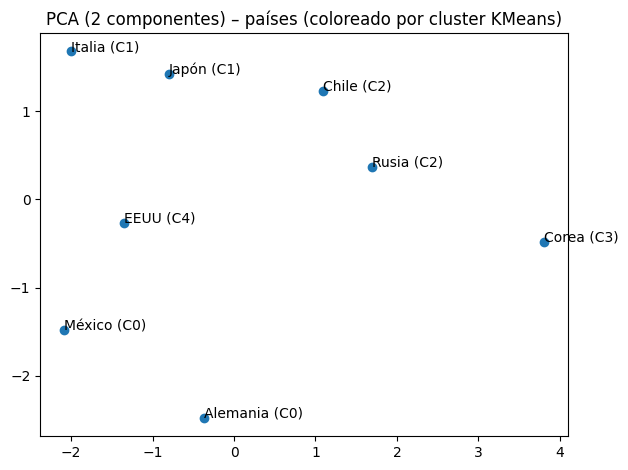

In [ ]:
# === 3) Reducción de dimensionalidad: PCA ===
pca = PCA().fit(X_scaled)
expl_var = pca.explained_variance_ratio_
cum_var = np.cumsum(expl_var)

print('Varianza explicada por componente:', np.round(expl_var, 4))
print('Varianza acumulada:', np.round(cum_var, 4))

# ¿Cuántos componentes para ≥90%?
n90 = int(np.argmax(cum_var >= 0.90) + 1)
print(f'Componentes necesarios para ≥90% de varianza: {n90}')

# Proyección 2D
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)

# Etiquetado con clusters de KMeans (mejor K)
label_scatter(X_pca2, countries, 'PCA (2 componentes) – países (coloreado por cluster KMeans)', cluster_assignments=labels_k_best)


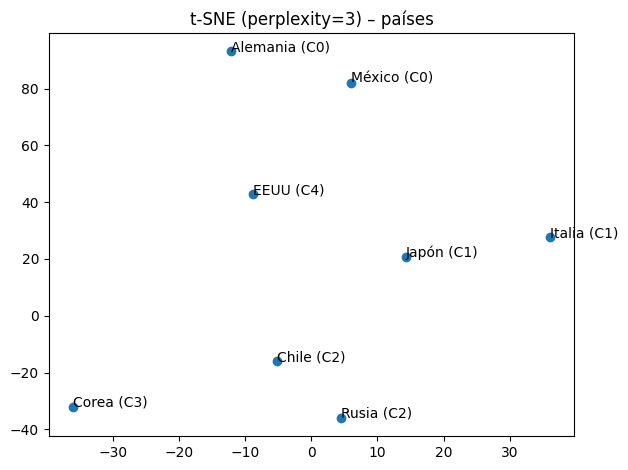

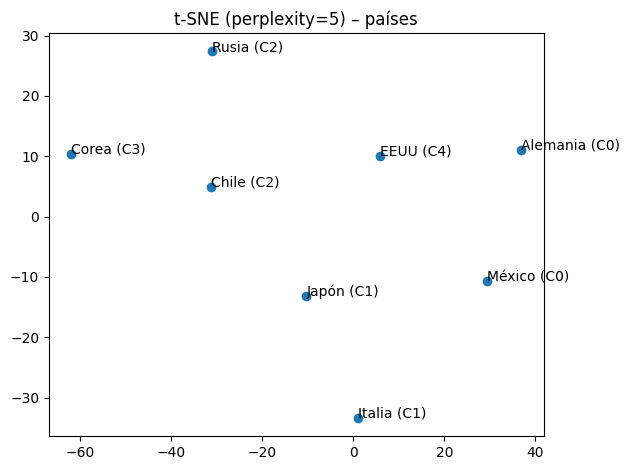

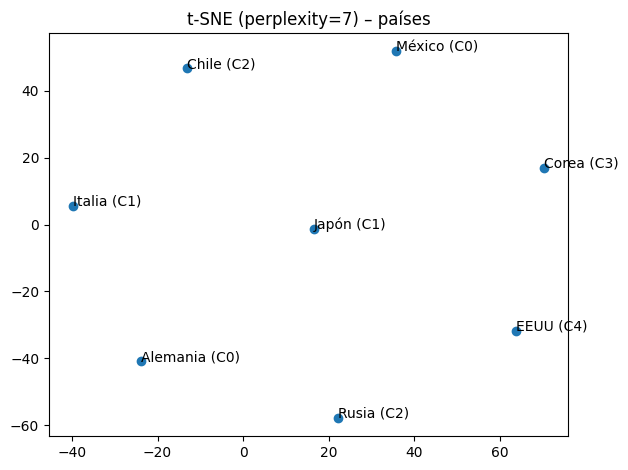

In [ ]:
# === t-SNE (2D) ===
# Con pocos puntos, usar perplexity baja (3-10). Probamos varias y graficamos.
# With n_samples = 8, perplexity must be less than 8.
perplexities = [3, 5, 7] # Adjusted perplexity values
for perp in perplexities:
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42, init='random', learning_rate='auto')
    X_tsne = tsne.fit_transform(X_scaled)
    label_scatter(X_tsne, countries, f't-SNE (perplexity={perp}) – países', cluster_assignments=labels_k_best)

## 4) Análisis de resultados y conclusiones

**Comparación de métodos**  
- *K-Means*: particiona el espacio en regiones convexas; requiere elegir **K**. Se evaluó con codo e índice de silueta.  
- *Jerárquico (Ward)*: construye una jerarquía de fusiones; el dendrograma ayuda a elegir el número de clusters. Suele ser estable con n pequeño.  
- *DBSCAN*: detecta densidades y marca ruido; con tan pocos países, es común que encuentre 1–2 clusters o mucho ruido según `eps` y `min_samples`.

**Cuál funcionó mejor y por qué**  
Con n pequeño y variables escaladas, K-Means y Ward tienden a dar particiones claras y comparables. DBSCAN puede ser sensible y menos informativo con muestras tan escasas.

**PCA vs t-SNE**  
- *PCA* preserva varianza global y permite interpretar **cuánta** varianza explican las componentes. Útil para justificar dimensionalidad (por ejemplo, ≥90%).  
- *t-SNE* prioriza vecindades locales; con n pequeño, diferentes `perplexity` pueden cambiar la proyección, pero sigue siendo útil para ver proximidades.

**Interpretación cultural**  
Revise la tabla de asignaciones para ver qué países caen juntos. Pregúntese si comparten idioma/región (p. ej., países hispanohablantes), influencia de ciertos géneros (p. ej., Reguetón, K‑Pop/Hip‑Hop en Asia), o tradición en *Clásica/Jazz*. Use estos hallazgos como hipótesis para tendencias globales de consumo musical y contraste con fuentes externas (mercados de streaming, charts regionales, etc.).
